In [1]:
# Install necessary libraries
!pip install tensorflow
!pip install tensorflow-datasets
!pip install tfds-nightly
!pip install matplotlib
!pip install PIL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.4 MB/s eta 0:00:0000:0100:01
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [2]:
# Distributing Learning to 2 T4 GPUS
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

In [3]:
# Dataset Path
data_dir = r"/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset"

# Image parameters
BATCH_SIZE = 32
batch_size_ = BATCH_SIZE * mirrored_strategy.num_replicas_in_sync
img_height = 224
img_width = 224

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size_
)

class_names = dataset.class_names
print(class_names)

Found 6900 files belonging to 80 classes.
['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']


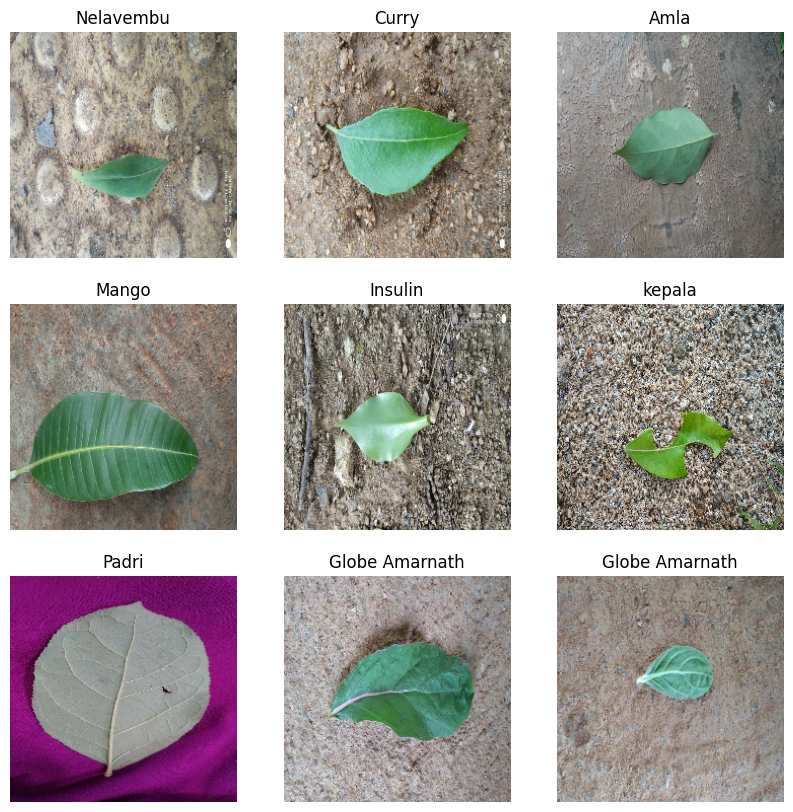

In [4]:
dataset_unbatched = dataset.unbatch()
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset_unbatched.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()

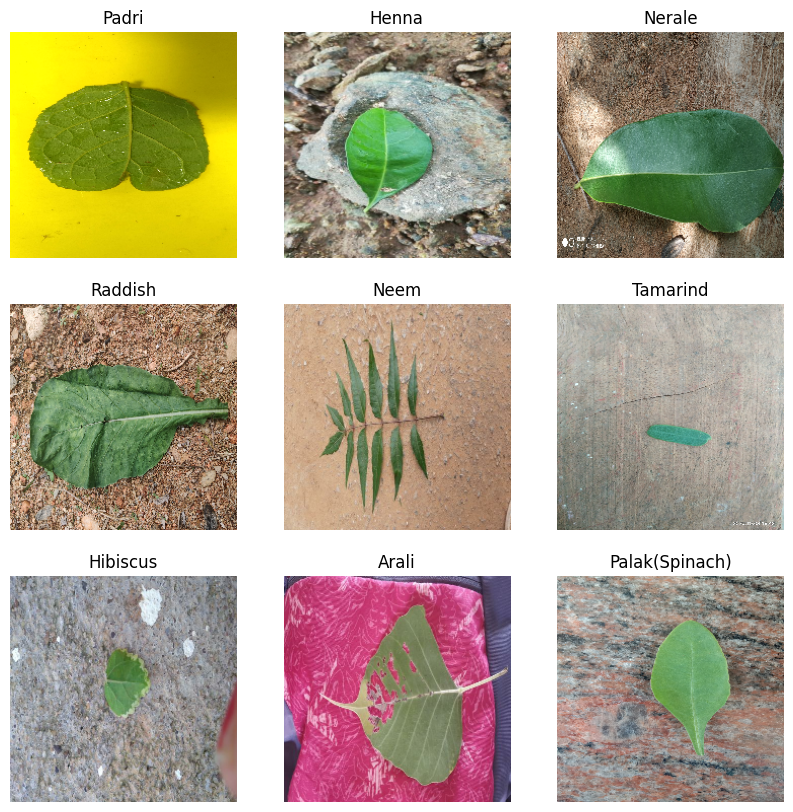

In [5]:
# Plotting Images for Visualization
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()   
        

In [6]:
# Train-Test Split
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimize dataset loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing and Rescaling Layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_height, img_height),
    layers.Rescaling(1./255),
])


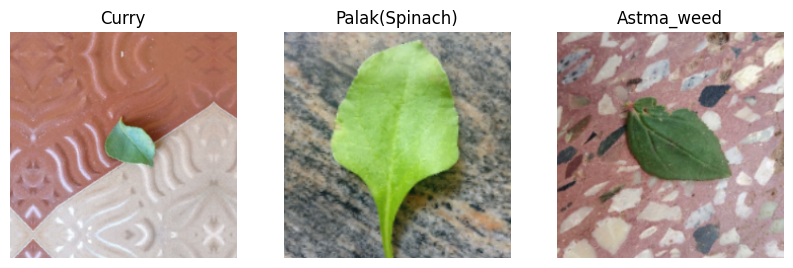

In [7]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
])

# Apply augmentation only on training set
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


# Plotting augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [8]:
# Load VGG16 Model (Feature Extractor)
feature_extractor = VGG16(input_shape=(224, 224, 3),
                          include_top=False,
                          weights="imagenet")

# Freeze VGG16 Layers
for layer in feature_extractor.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


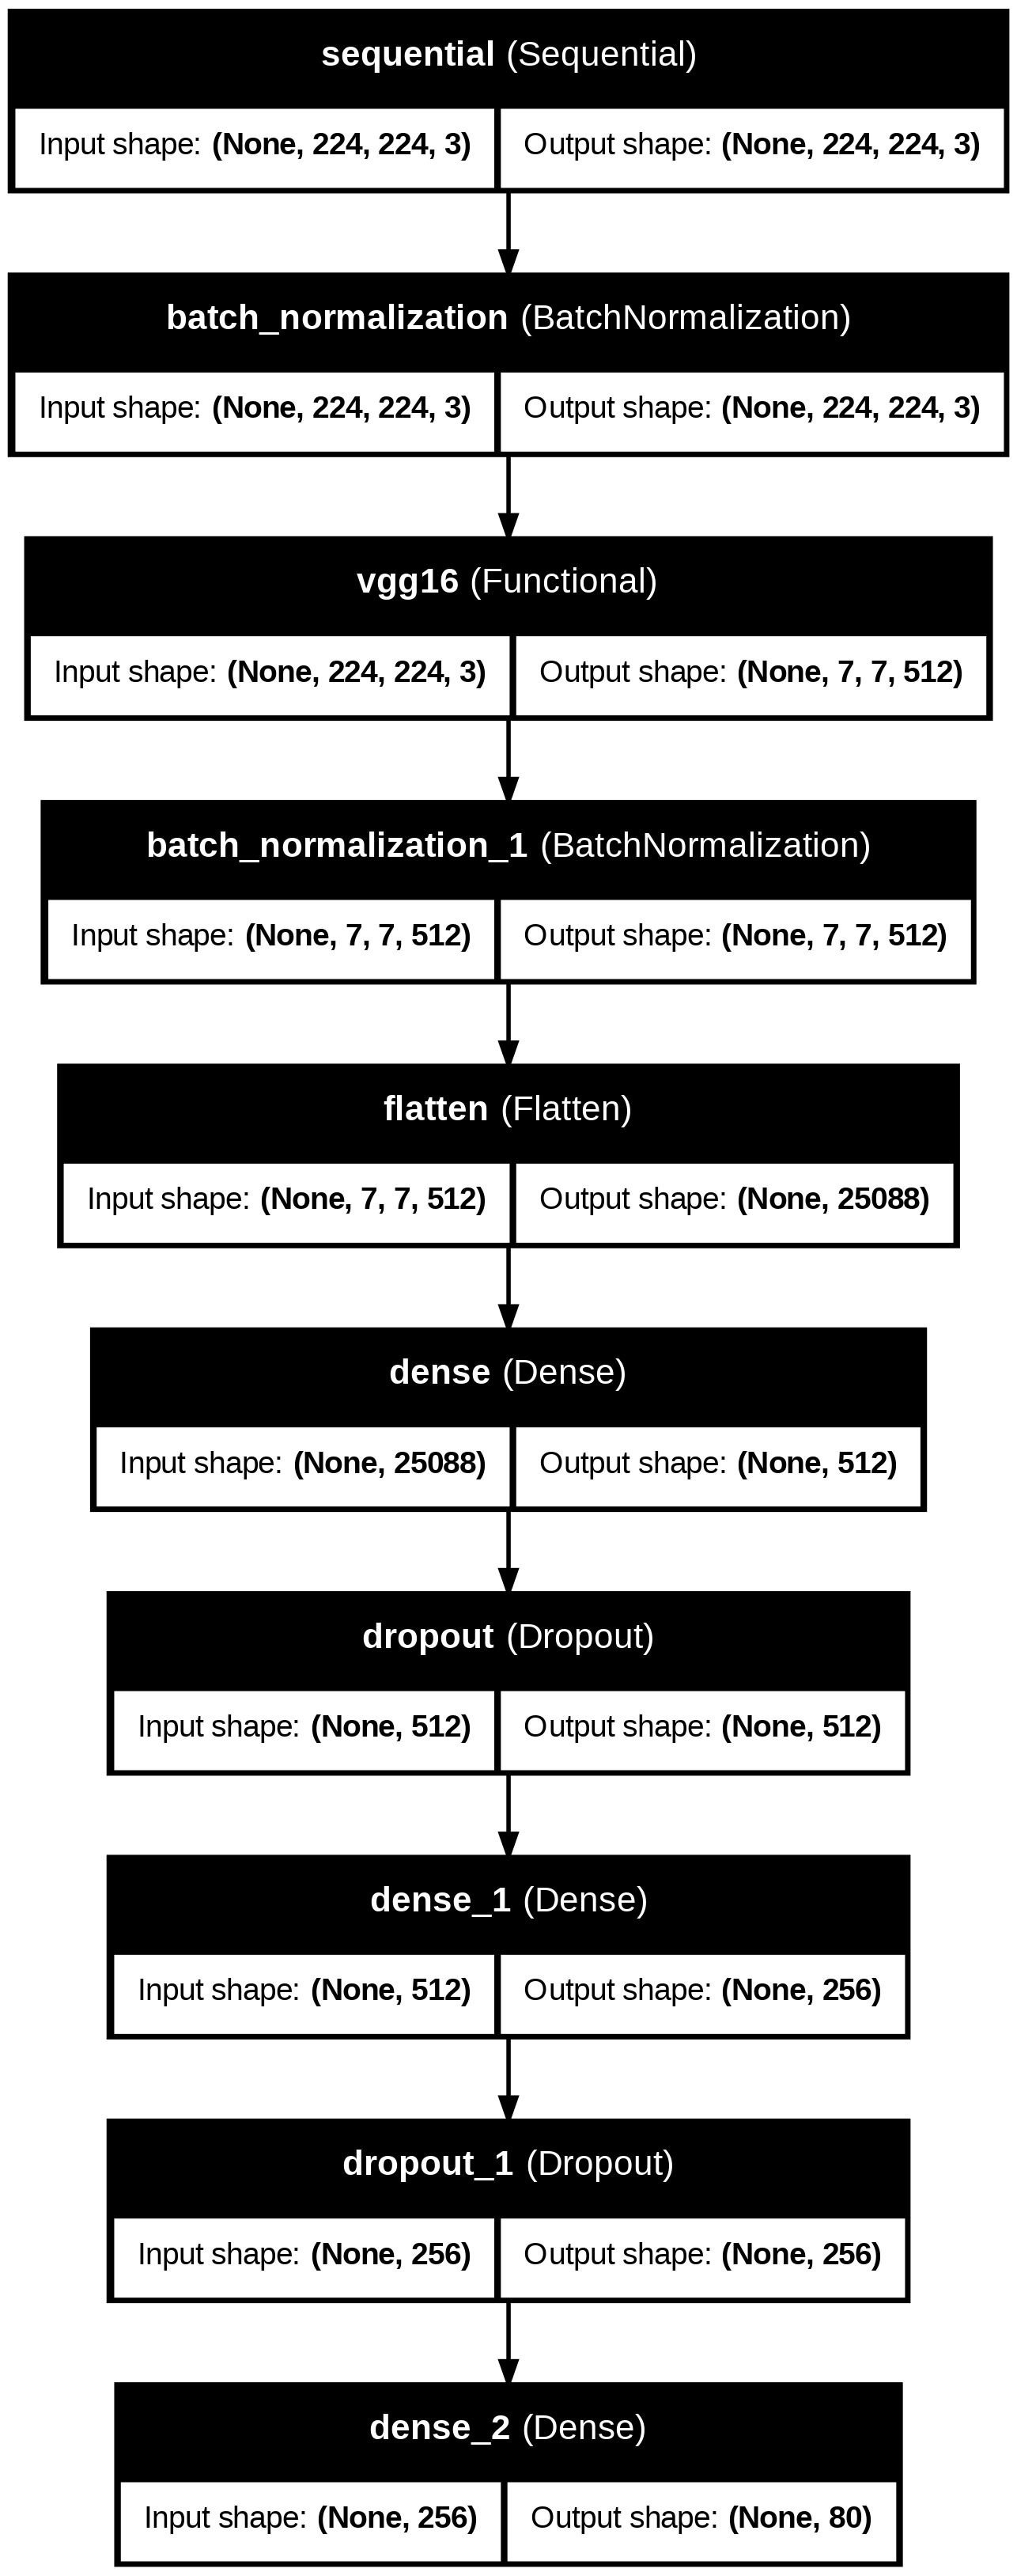

In [9]:
# Define Model Architecture with Regularization
with mirrored_strategy.scope():
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),  # Explicit input layer
        resize_and_rescale,
        layers.BatchNormalization(),

        feature_extractor,
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 Regularization
        layers.Dropout(0.4),  # Increased Dropout to 40%
        
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 Regularization
        layers.Dropout(0.4),

        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

# Visualize Model Architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png', width=400, height=800)

In [10]:
# Define Callbacks to Prevent Overfitting
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=7, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

callback_list = [earlystopping, reduce_lr]

In [11]:
# Train Model
model_history = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=150,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.0269 - loss: 6.2035 - val_accuracy: 0.1172 - val_loss: 5.4593 - learning_rate: 1.0000e-04
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 865ms/step - accuracy: 0.1230 - loss: 5.2155 - val_accuracy: 0.3027 - val_loss: 5.0186 - learning_rate: 1.0000e-04
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 857ms/step - accuracy: 0.2090 - loss: 4.7126 - val_accuracy: 0.4746 - val_loss: 4.2652 - learning_rate: 1.0000e-04
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 857ms/step - accuracy: 0.2767 - loss: 4.3415 - val_accuracy: 0.6074 - val_loss: 3.5418 - learning_rate: 1.0000e-04
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 874ms/step - accuracy: 0.3469 - loss: 3.9878 - val_accuracy: 0.6797 - val_loss: 3.0024 - learning_rate: 1.0000e-04
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 874ms/step - accuracy: 0.3803 - loss: 3.8135 - val_accuracy: 0.7578 - val_loss: 2.6244 - learning_rate: 1.0000e-04
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 848ms/step 

In [12]:
with mirrored_strategy.scope():
    # Clone the trained model architecture and load the weights
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())

    # Find the feature extractor layer in the cloned model.
    feature_extractor_clone = None
    for layer in new_model.layers:
        # Check if the layer is a model and likely the VGG16 feature extractor.
        if isinstance(layer, tf.keras.Model) and layer.name.startswith("vgg16"):
            feature_extractor_clone = layer
            break

    if feature_extractor_clone is None:
        raise ValueError("Could not find the feature extractor layer in the cloned model.")

    # Unfreeze the last 10 layers of the feature extractor for fine-tuning.
    for layer in feature_extractor_clone.layers[-10:]:
        layer.trainable = True

    # Re-compile the model for fine-tuning with a lower learning rate.
    new_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    # Continue training with fine-tuning.
    model_history_finetune = new_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,  # Fewer epochs for fine-tuning
        callbacks=callback_list,
        verbose=1
    )


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 862ms/step - accuracy: 0.8827 - loss: 1.6040 - val_accuracy: 0.9648 - val_loss: 1.3117 - learning_rate: 1.0000e-05
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 885ms/step - accuracy: 0.8992 - loss: 1.5347 - val_accuracy: 0.9668 - val_loss: 1.3200 - learning_rate: 1.0000e-05
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 875ms/step - accuracy: 0.9131 - loss: 1.5141 - val_accuracy: 0.9609 - val_loss: 1.3191 - learning_rate: 1.0000e-05
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9102 - loss: 1.5033
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 869ms/step - accuracy: 0.9101 - loss: 1.5035 - val_accuracy: 0.9551 - val_loss: 1.3316 - learning_rate: 1.0000e-05
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 867ms/step - accuracy: 0.9073 - loss: 1.4875 - val_accuracy: 0.9766 - val_loss: 1.2797 - learning_rate: 5.0000e-06
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 880ms/step - accuracy:

In [16]:
# Save model
new_model.save("vgg16_finetuned_model2.keras")

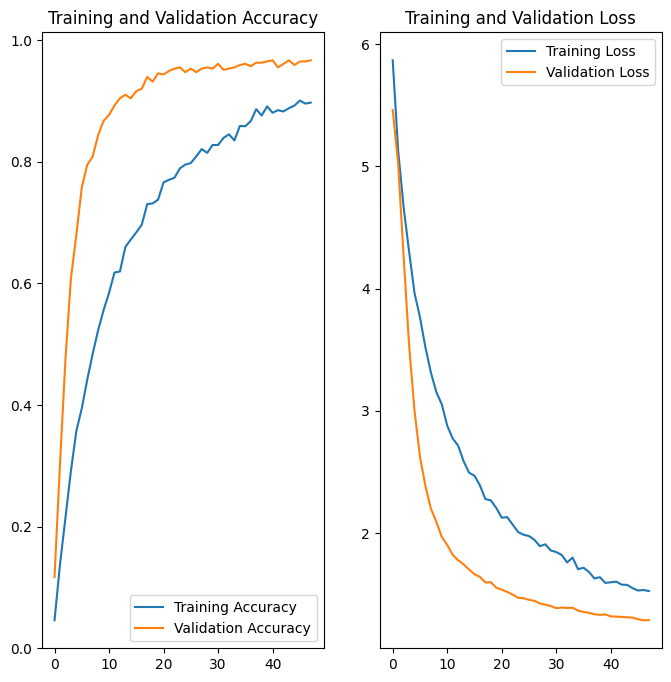

In [14]:
# Loss and accuracy graph
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


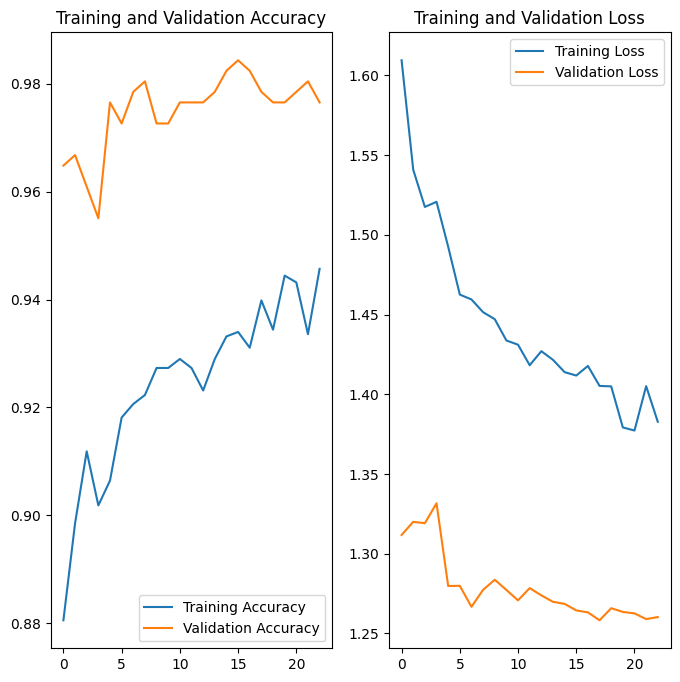

In [17]:
acc = model_history_finetune.history['accuracy']
val_acc = model_history_finetune.history['val_accuracy']

loss = model_history_finetune.history['loss']
val_loss = model_history_finetune.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
# Evaluating the model on test data
model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.9694 - loss: 1.3313


[1.329543948173523, 0.9724264740943909]

In [18]:
new_model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.9575 - loss: 1.3548


[1.2771923542022705, 0.9797794222831726]

In [19]:
### WITHOUT FINE TUNING ###

# Evaluation metrics - classification Report, precision, recall, f1 score etc.
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Function to predict a single image
def predict(model, image):
    predictions = model.predict(np.expand_dims(image, axis=0), verbose=0)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    return predicted_class, confidence

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    for i in range(len(labels)):
        true_labels.append(labels[i].numpy())
        predicted_class, _ = predict(model, images[i].numpy())
        predicted_labels.append(predicted_class)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9618
Recall: 0.9586
F1 Score: 0.9586


In [24]:
### WITH FINE TUNING ###

# Predict on the entire test dataset
true_labels = []
predicted_labels = []

# Unbatch dataset for efficient processing
for image, label in test_ds.unbatch():
    true_labels.append(label.numpy())
    prediction = new_model.predict(np.expand_dims(image.numpy(), axis=0), verbose=0)
    predicted_labels.append(np.argmax(prediction))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate classification metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Accuracy: 0.9660
Precision: 0.9691
Recall: 0.9660
F1 Score: 0.9658

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00        14
           7       0.91      0.91      0.91        11
           8       0.95      1.00      0.97        19
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        12
          11       1.00      0.92      0.96        12
          12       0.91      1.00      0.95        10
          13       1.00      0.96      0.98        23
          14       1.00      1.00      1.00        21
          15       1.00      1.00      1.00 

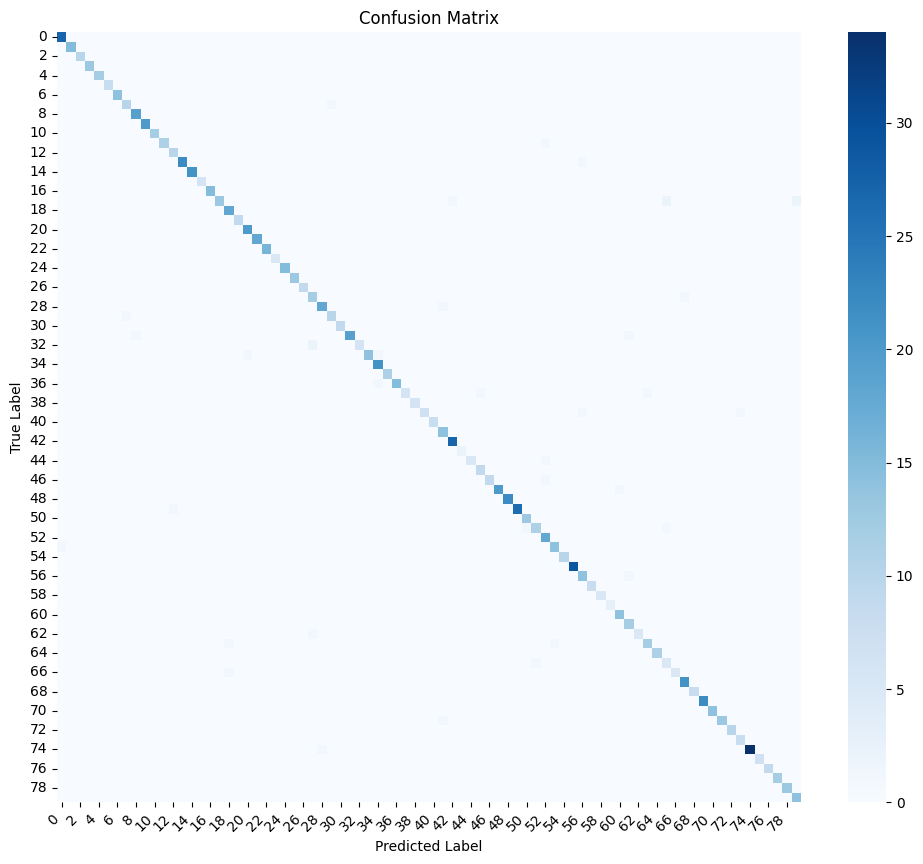

In [25]:
# Plot Confusion Matrix
plt.figure(figsize=(12, 10))  # Increase figure size

sns.heatmap(conf_matrix, annot=False, cmap="Blues", fmt="d")  # Remove annotations for clarity
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

# Ensure true_labels and predicted_labels exist
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Copy confusion matrix to avoid modifying the original
conf_matrix_copy = conf_matrix.copy()
np.fill_diagonal(conf_matrix_copy, 0)  # Remove correct predictions

N = 5  # Number of top misclassifications
top_misclass_indices = np.dstack(np.unravel_index(np.argsort(-conf_matrix_copy, axis=None), conf_matrix_copy.shape))[0]

print("Top misclassifications:")
for i in range(N):
    row, col = top_misclass_indices[i]
    true_class = class_names[row]
    predicted_class = class_names[col]
    count = conf_matrix[row, col]
    
    if count > 0:  # Avoid printing zero misclassifications
        print(f"True class: {true_class}, Predicted class: {predicted_class}, Count: {count}")


Top misclassifications:
True class: Citron lime (herelikai), Predicted class: kepala, Count: 2
True class: Citron lime (herelikai), Predicted class: Sapota, Count: 2
True class: Henna, Predicted class: Ganike, Count: 2
True class: Tulsi, Predicted class: Gasagase, Count: 1
True class: Rose, Predicted class: Onion, Count: 1
